<a href="https://colab.research.google.com/github/Mudachir/IMAGE-BASED-DETECTION-AND-CLASSIFICATION-OF-PULMONARY-ABNORMALITIES-USING-DEEP-LEARNING-TECHNIQUES/blob/main/CNN_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transfer Learning

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the paths to the folders
covid_path = '/content/drive/MyDrive/Dataset/COVID'
normal_path = '/content/drive/MyDrive/Dataset/Normal'
lung_opacity_path = '/content/drive/MyDrive/Dataset/Lung_Opacity'
viral_pneumonia_path = '/content/drive/MyDrive/Dataset/Viral Pneumonia'

In [ ]:
# Load the images and labels for each class
def loadImages(path, urls, target):
    images = []
    labels = []
    for i in range(len(urls)):
        img_path = path + "/" + urls[i]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if img is None:
            continue
        img = img / 255.0
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(target)
    images = np.asarray(images)
    return images, labels


In [ ]:
# Load images from all categories
covidUrls = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrls, 0)  # 0 for COVID

normalUrls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normalUrls, 1)  # 1 for Normal

lungOpacityUrls = os.listdir(lung_opacity_path)
lungOpacityImages, lungOpacityTargets = loadImages(lung_opacity_path, lungOpacityUrls, 2)  # 2 for Lung Opacity

viralPneumoniaUrls = os.listdir(viral_pneumonia_path)
viralPneumoniaImages, viralPneumoniaTargets = loadImages(viral_pneumonia_path, viralPneumoniaUrls, 3)  # 3 for Viral Pneumonia

In [ ]:
# Combine the images and labels
data = np.r_[covidImages, normalImages, lungOpacityImages, viralPneumoniaImages]
targets = np.r_[covidTargets, normalTargets, lungOpacityTargets, viralPneumoniaTargets]
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.25, random_state=42)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)

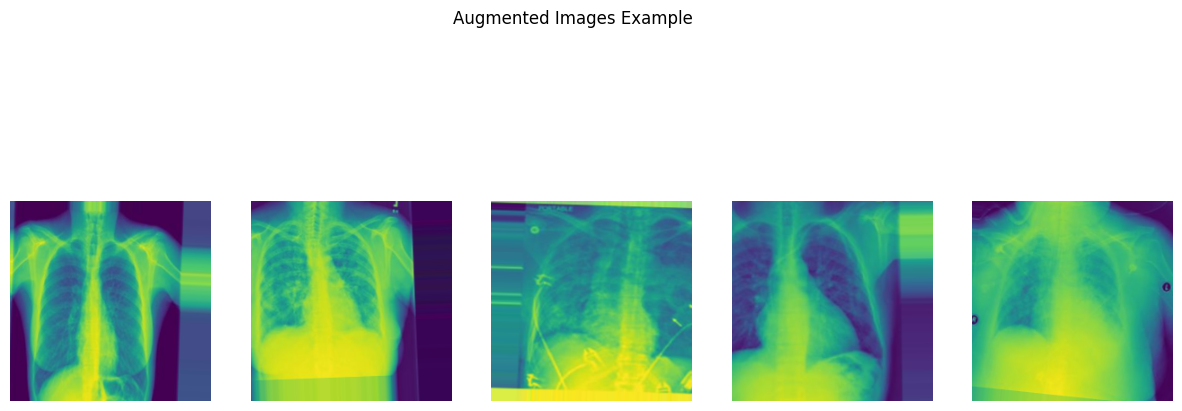

In [ ]:
# Visualize augmented images
augmented_images, _ = next(datagen.flow(x_train, y_train, batch_size=5))
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Images Example')
plt.show()


In [ ]:
# Load a pre-trained model (VGG16) and fine-tune the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers of VGG16 to retain pretrained features
for layer in base_model.layers[10:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Define the updated model
model = Sequential([
    base_model,
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.3),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.4),
    BatchNormalization(),
    Dropout(0.4),
    Dense(4, activation='softmax')  # 4 classes for output
])

In [ ]:
class_weights = {0: 1.0, 1: 1.2, 2: 1.1, 3: 1.0}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_using_cnn_with_vgg16(2).weights.h5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:

import os
if os.path.exists('/content/drive/MyDrive/best_model_using_cnn_with_vgg16(2).weights.h5'):
    model.load_weights('/content/drive/MyDrive/best_model_using_cnn_with_vgg16(2).weights.h5')
else:
    print("Model file not found. Please check if the model has been saved correctly.")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Train the model with a reduced batch size
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 136s 910ms/step - accuracy: 0.8984 - loss: 0.6338 - val_accuracy: 0.8645 - val_loss: 0.7139 - learning_rate: 1.0000e-06
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 528ms/step - accuracy: 0.9022 - loss: 0.6244 - val_accuracy: 0.8825 - val_loss: 0.6671 - learning_rate: 1.0000e-06
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 529ms/step - accuracy: 0.9010 - loss: 0.6336 - val_accuracy: 0.9043 - val_loss: 0.6243 - learning_rate: 1.0000e-06
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 506ms/step - accuracy: 0.9141 - loss: 0.6159 - val_accuracy: 0.9014 - val_loss: 0.6282 - learning_rate: 1.0000e-06
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 506ms/step - accuracy: 0.9226 - loss: 0.5846 - val_accuracy: 0.8853 - val_loss: 0.6886 - learning_rate: 1.0000e-06
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9238 - loss: 0.5847
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 506ms/step - accuracy: 0.9238 - 

In [ ]:
# Summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,446,286 (169.55 MB)

 Trainable params: 14,815,172 (56.52 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 29,630,346 (113.03 MB)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step
Accuracy: 0.90
Precision: 0.91
Recall (Sensitivity): 0.90
F1 Score: 0.90
Confusion Matrix:
[[261  10  16   1]
 [ 11 203  32   0]
 [  3  15 250   1]
 [  0  12   0 240]]


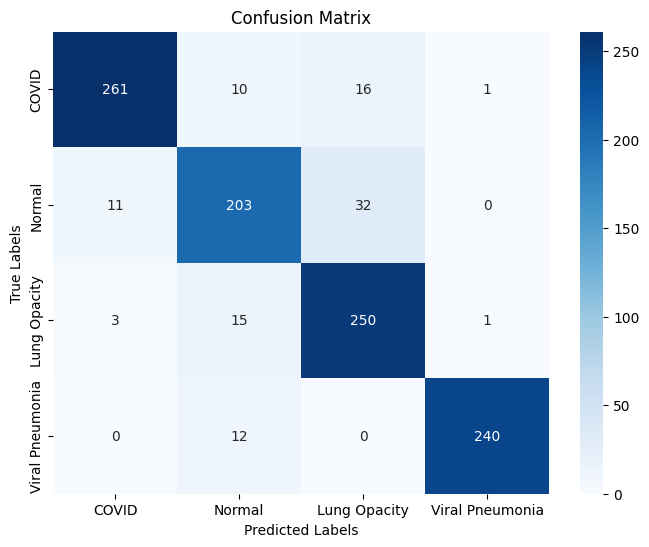

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with class names
class_names = ['COVID', 'Normal', 'Lung Opacity', 'Viral Pneumonia']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Available keys in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


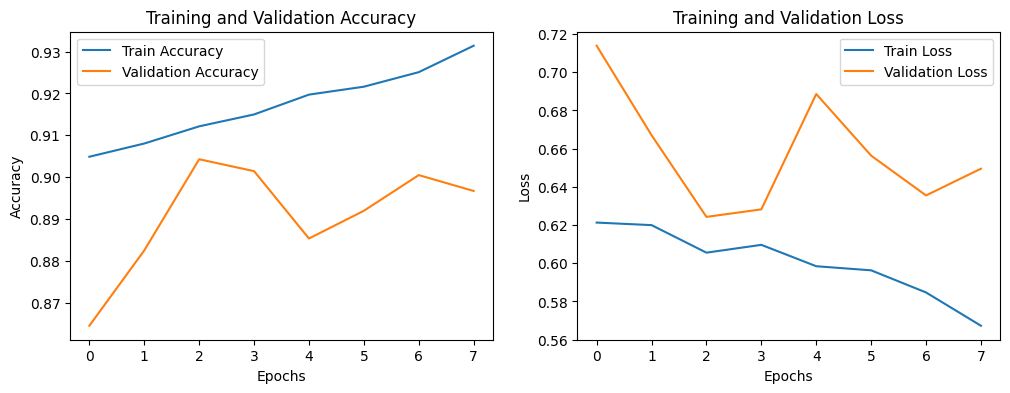

In [ ]:
history_data = history.history

# Print available keys in the history to determine correct metrics names
print('Available keys in history:', history_data.keys())

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
if 'accuracy' in history_data:
    plt.plot(history_data['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history_data:
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
if 'loss' in history_data:
    plt.plot(history_data['loss'], label='Train Loss')
if 'val_loss' in history_data:
    plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# Step 7: Disconnect from Colab GPU to save compute units
from google.colab import runtime
runtime.unassign()
print("Disconnected from GPU to save compute units.")
